In [1]:
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn 
warnings.filterwarnings("ignore", category=UserWarning)

from scipy.spatial.distance import cosine, euclidean, cdist
import tensorflow 

import PIL
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers  
# %load_ext nb_black
from tqdm.notebook import tqdm 
  
from skimage.filters import try_all_threshold, threshold_otsu
from tensorflow.keras.applications import resnet, EfficientNetB0
from sklearn.metrics import roc_curve

tf.random.set_seed(2018) 
np.random.RandomState(2018)
random.seed(2018) 

CEDAR_PATH = "signatures" 
!rm -rf traindata td
!mkdir -p traindata/train/train
!mkdir -p traindata/val/val
!mkdir models

mkdir: models: File exists


In [2]:
# Utility Functions

def threshold_image(img_arr):
  thresh = threshold_otsu(img_arr)
  return np.where(img_arr > thresh, 255, 0)

def load_img_np(img_path, resize=False):
  img_np = load_img(img_path)
  if resize:
    img_np = load_img(img_path, target_size=img_target_size)
  img_np = np.squeeze(img_to_array(img_np))  
  img_np = threshold_image(img_np)  
  return img_np

def visualize_predictions(model, val_ds):
  # get a batch of validation examples
  (test_aug, test_clean) = next(iter(val_ds)) 
  predicted_test = model.predict(test_aug)
  plt.figure(figsize=(18, 10))
  for aug, clean in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      clean_aug = np.concatenate((test_aug[i].numpy() ,predicted_test[i], test_clean[i].numpy() ), axis =1)
      plt.imshow(clean_aug)
      plt.axvline(x=224, color='g', label='axvline - full height')
      plt.axvline(x=448, color='g', label='axvline - full height')
      plt.title("   Noisy Input | Prediction | Ground Truth ") 
      plt.axis("off")


def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False)

def SSIM(y_true, y_pred): 
  # betweeen 0 and 1. Higher the better
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def PSNR(y_true, y_pred): 
    # should be between 30 and 50. Higher the better
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
    
def plot_vals(ax,history, metric_title, model_name):
  ax.plot(history.history[metric_title])
  ax.plot(history.history['val_' + metric_title])
  ax.set_title(model_name + ' | ' + metric_title + " | " + str(round(history.history['val_' + metric_title][-1],2)) )
  ax.set_ylabel(metric_title.upper())
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper left')

def plot_history(history, title=""):  
  fig, axes = plt.subplots(2,2, figsize=(12,10))
  metric_list = ["loss","rmse","PSNR","SSIM"]

  for i, ax in enumerate(axes.flatten()): 
    plot_vals(ax, history, metric_list[i], title) 

  plt.tight_layout()
  plt.show()

In [3]:
# download a set of fonts for use in the simulator
!rm -rf fonts
!git clone https://github.com/victordibia/fonts 
    
# download a list of words for use as background text     
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
words = [x.decode() for x in response.content.splitlines()]

# list of font types to exclude
font_list = []
excluded_font_types = ["Light", "Medium"]  # ["Bold","Italic", "Light", "Medium"]

def is_font_valid(font): 
  for val in excluded_font_types:
    if val.lower() in font.lower():
      return False
  return True

for path, subdirs, files in os.walk("fonts/fonts"):
    for name in files:
        font_path = os.path.join(path, name)
        if (is_font_valid(font_path) and font_path.split(".")[1] == "ttf"):
          font_list.append(font_path)    

Cloning into 'fonts'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 94 (delta 8), reused 88 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 5.86 MiB | 738.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [4]:
from random import randint
import string 

# Some words like more likely to be found around a signature - names, honorifics, prefixes, suffixes, titles. 
# Perhaps we can get the data generator to always add them such that the model gets really good at discovering and removing those words 
primary_words = ["Board of Trustees", "Trustee", "Meeting", "Board", "Best Wishes", "Wishes", "Best", "Yours Truly ", "Yours" , "Sincerely", "Best Wishes", "President", "Chairman", "Phd"]


def get_pil_font(): 
  # Randomly select a font from a list of common fonts  
  font_path = font_list[randint(0,len(font_list) -1)] 
  try:
      font = ImageFont.truetype(font_path, random.randint(25,55))
  except IOError:
      font = ImageFont.load_default()
  return font

def get_word(add_primary=False): 
  # based on probabilities, get a single or double word, which may be lower or upper or capitalize case.
  word = words[random.randint(0, len(words)-1)] 
  if random.random() > 0.7:
    word = word + " " + primary_words[random.randint(0, len(primary_words)-1)]

  prob = random.random()
  if prob < 0.25:
    return word.lower()
  if prob > 0.25 and prob <  0.75:
    return word.upper()
  if prob > 0.75:
    return word.capitalize()

def get_text():
  # get augmentation text as random punctuations + words
  punctuations = string.punctuation 
  text =  get_word() + " " + punctuations[random.randint(0, len(punctuations) -1)] + " " + get_word()    
  if random.random() > 0.5:
    text = text + " " + get_word()
  return text

def draw_line(img_size=(224,224)):
  img = Image.new('L', img_size, color = (255))
  draw = ImageDraw.Draw(img)
  im_width, im_height = img_size 
  
  # draw two random words from the MIT wordlist  
  text = get_text() 

  # randomly place horizontal line  in one of three locations
  y_pos_list = [im_height*0.2, im_height*0.5, im_height*0.8]
  y_pos = y_pos_list[random.randint(0, len(y_pos_list)-1)]

  line_shape = [( random.randint(0,80) ,y_pos ), (im_width - random.randint(0,80), y_pos  )]
  # line_shape = [( 0,y_pos ), (im_width , y_pos  )]
  draw.line(line_shape, fill="black", width=random.randint(1,9))

  # draw a shorter line segment
  hy_pos = random.randint(80, im_height)
  half_line_shape = [(random.randint(int( im_width *0.25), im_width) ,hy_pos ), (random.randint(int( im_width *0.25), im_width) , hy_pos  )]
  draw.line(half_line_shape, fill="black", width=random.randint(1,9))

  mask = Image.fromarray(np.uint8(255*(np.random.rand(im_height,im_width ) > random.uniform(0.75, 1))))
  draw.text((random.randint(50,170), y_pos + random.randint(2,20)), text, fill="black", font=get_pil_font()) 
  img.paste(mask,(0,0), mask) 

  return img 

def draw_text(img_size=(224,224), font_size=30):
  #draw words from MIT wordlist
  text = get_text()

  im_width, im_height = img_size
  img = Image.new('L', img_size, color = (255))
  draw = ImageDraw.Draw(img)

  # randomly place text at one of three x,y locations
  y_pos_list = [im_height*0.2, im_height*0.5, im_height*0.8]
  y_pos = y_pos_list[random.randint(0, len(y_pos_list)-1)]


  x_pos_list = [0, im_width*0.1, im_width*0.2]
  x_pos = x_pos_list[random.randint(0, len(x_pos_list)-1)]

  draw.text((x_pos,y_pos), text, fill="black", font=get_pil_font()) 

  mask = Image.fromarray(np.uint8(255*(np.random.rand(im_height,im_width) > random.uniform(0.98, 1))))  
  return img
 

def get_aug(img_paths, img_target_size=(224, 224)):
  # for each image in img_paths, load image, generate noisy version, return both clean and noisy version
  aug_holder = []
  clean_holder = []
  
  for img_path in img_paths: 
    img_np =  load_img_np(img_path)

    # img_np = threshold_image(img_np)   
    image = Image.fromarray(np.uint8(img_np)).convert('RGB') 
    clean_image = image.resize((img_target_size))
    clean_holder.append( threshold_image(np.array(clean_image)) * (1./255))  
    im_width, im_height = image.size  
    bg = draw_line(img_size=image.size) 

    # randomly add  text 
    if random.random() > 0.5:
      bg.paste(draw_text(img_size=image.size), (0,0), bg)

    # randomly add another text 
    if random.random() > 0.5:
      bg.paste(draw_text(img_size=image.size), (0,0), bg) 
    
    img_mask = image.convert('L') 
    image.paste(bg,(0,0), img_mask)

    # resize image to target size
    image = (image.resize((img_target_size))) 
    aug_holder.append( threshold_image(np.array(image)) * (1./255)) 

  return np.array(clean_holder), np.array(aug_holder)

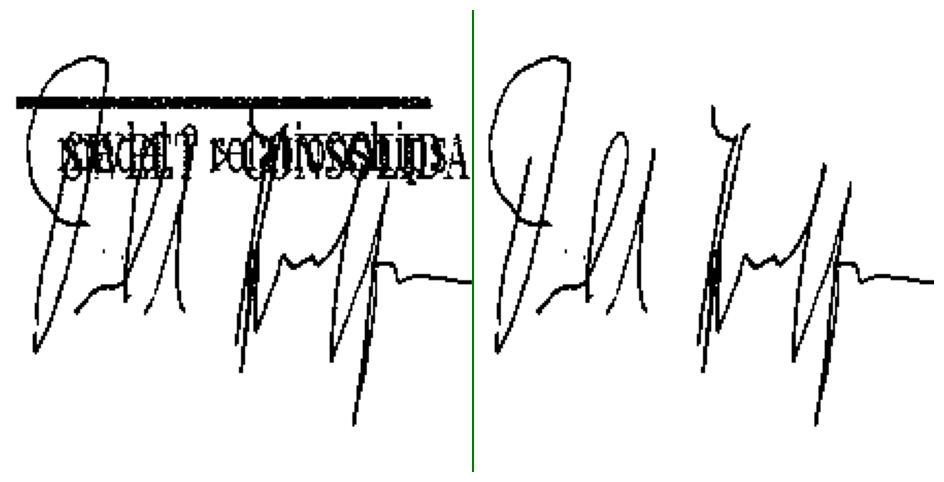

In [5]:
img_paths = [f"{CEDAR_PATH}/full_forg/forgeries_10_1.png",f"{CEDAR_PATH}/full_forg/forgeries_10_2.png"] 
clean, auggy = get_aug(img_paths)
plt.figure(figsize = (20,6))
plt.axis('off')
plt.imshow(np.concatenate((auggy[0],clean[0]), axis=1) );
plt.axvline(x=224, color='g', label='axvline - full height');

In [6]:
holdout_signers = [2,5,15,6,19,22,51,34,48,30] 
holdout_names = ["original_" + str(x) + "_" for x in holdout_signers] + [ "forgeries_" + str(x) + "_" for x in holdout_signers]
print(f"We hold out genuine/forgeries associated with  {len(holdout_signers)} signers.")

We hold out genuine/forgeries associated with  10 signers.


In [7]:
all_images = []
for path, subdirs, files in os.walk(CEDAR_PATH):
    for name in files:
        image_path = os.path.join(path, name)
        if "png" in image_path:
          all_images.append(image_path)   

train_images = []
val_images = []

def is_holdout(img_path):
  for name in holdout_names:
    if name in img_path:
      return True 
  return False

for img in tqdm(all_images):
  if is_holdout(img):
    val_images.append(img) 
  else:
    train_images.append(img) 

print(f"Processed {len(all_images)} images | {len(train_images)} train ; {len(val_images)} validation" )

  0%|          | 0/2640 [00:00<?, ?it/s]

Processed 2640 images | 2160 train ; 480 validation


In [8]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_images)).shuffle(5, seed=123).repeat(3).batch(batch_size) 
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_images)).batch(batch_size) 

def generate_pair(x):  
  clean, aug = get_aug(x.numpy()) 
  return (aug, clean)

train_ds = train_ds.map(lambda x, y: tf.py_function(generate_pair, [x], [tf.float32,tf.float32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(generate_pair, [x], [tf.float32,tf.float32])) 

2024-10-12 16:37:08.183881: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-10-12 16:37:08.183912: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-12 16:37:08.183924: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-12 16:37:08.184212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-12 16:37:08.184256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-10-12 16:37:09.417087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


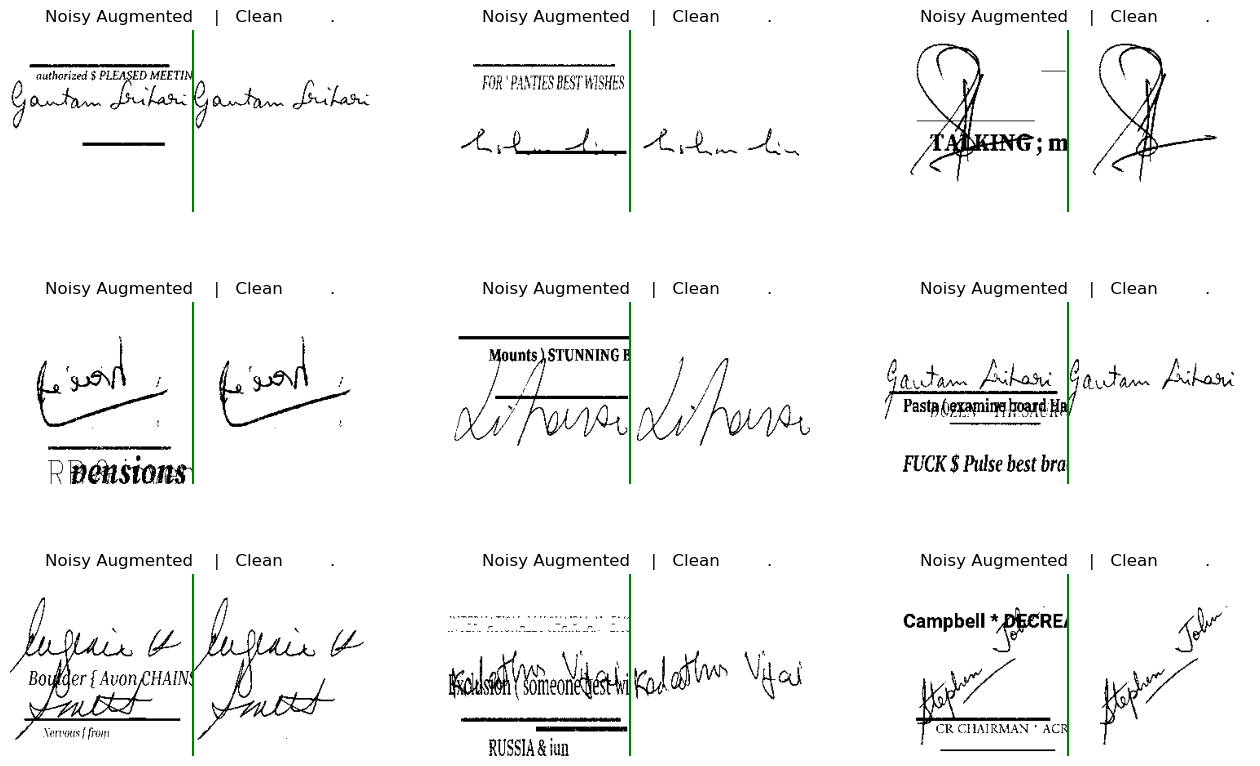

In [9]:
plt.figure(figsize=(16, 10))
for aug, clean in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    clean_aug = np.concatenate((aug[i].numpy(), clean[i].numpy() ), axis =1)
    plt.imshow(clean_aug)
    plt.axvline(x=224, color='g', label='axvline - full height')
    plt.title("Noisy Augmented    |   Clean         . ")
    plt.axis("off")

In [10]:
#we can use caching and prefetching to improve performance 
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
def get_autoencoder(input_shape=(224,224,3), num_layers = 4, num_filters = 64): 
    
  input = layers.Input(shape=input_shape)
  x = input
  
  # Encoder
  for i in range(num_layers): 
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) 
    num_filters = num_filters * 2
  
  x = layers.Dropout(0.2)(x)
  
  # Decoder
  for i in range(num_layers): 
    num_filters = num_filters /2
    x = layers.Conv2DTranspose(num_filters, (3, 3), strides=2, activation="relu", padding="same")(x) 
     
  x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x) 
  # Autoencoder
  autoencoder = Model(input, x, name="autoencoder")

  initial_learning_rate = 0.004
  # tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.80,
    staircase=False)
  
  autoencoder.compile(optimizer="adam", loss="binary_crossentropy",metrics=[PSNR, tf.keras.metrics.RootMeanSquaredError(name="rmse"), SSIM])
  return autoencoder

In [12]:
ae = get_autoencoder(num_layers=3)
ae.summary() 

ValueError: Cannot convert '(3, 3, 256.0, 256)' to a shape. Found invalid entry '256.0' of type '<class 'float'>'. 

In [ ]:
def train_autoencoder(ae, epochs=4):
  history = ae.fit(
      train_ds,
      epochs=epochs, 
      validation_data=val_ds,
  ) 
  plot_history(history, title="Convolutional Autoecoder")
train_autoencoder(ae,epochs=10)

In [ ]:
visualize_predictions(ae, val_ds)


In [ ]:
def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False)

save_model("autoencoder", ae)